# Variational Circuits in Qiskit

This notebook is an introduction to how to create variational circuits in Qiskit and how we can connnect it to a classical optimizer to prepare a target state vector. This is based on the variational method in quantum mechanics for finding an upper bound on the minimum eigenvalue, however here will just be measuring state fidelity.

Further information can be found at the following links:


*   https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html
*   https://qiskit.org/ecosystem/ibm-runtime/tutorials/vqe_with_estimator.html
*   https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html
*   https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html#qiskit.circuit.library.TwoLocal

We will consider two methods for creating our variational form, one manually and one using a built-in Qiskit library.

Once you've identified an appropriate variational form you then need to optimize its parameters. A whole host of optimizers are available through Qiskit here (https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html). We note some below:

*   We focus on COBYLA in this notebook, this is a non-gradient based classical optimiser and suitable for noiseless objective functions.
*   Gradient-descent is typically not recommened for variational problems, this optimization strategy often gets stuck at poor local optima and is relatively expensive in terms of the number of circuit evaluations performed.  
*   SPSA is more appropriate for noisy objective functions



1.   **Example with 3 Qubits and repeated variational form to find circuit that creates target state vector**

In [7]:
# Library Imports
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile, assemble
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, GradientDescent
from qiskit.quantum_info import state_fidelity
from qiskit.circuit.library import EfficientSU2


Create a random 3 Qubit state vector that we want to prepare. Choosing the seed to start with will always choose the same random state vector.

In [8]:
num_qbits = 3

# Create random probability vector
np.random.seed(999999)
target_dist = np.random.rand(2**num_qbits)
# Now convert the random vector into a valid state vector
target_state = target_dist/np.sqrt(sum(np.abs(target_dist)**2))
#target_state = (1/(2*np.sqrt(2)))*np.array([1, 1, 1, 1, 1, 1, 1, 1])
Statevector(target_state).draw('latex')


<IPython.core.display.Latex object>

First we show a manual method for creating our variational circuit given a set of parameters. Ensure you follow how parameters are mapped to a given quantum gate.


In [9]:
# Create Single 3 Qubit variational form given a QuantumCircuit
def add_var_form(qc, current_rep, params):
  num_qubits = len(qc.qubits)
  for current_qubit_index in range(num_qubits):
    qc.rx(params[2*(current_qubit_index) + 6*current_rep], current_qubit_index)
    qc.rz(params[2*(current_qubit_index) + 6*current_rep + 1], current_qubit_index)
  for current_qubit_index in range(num_qubits):
    if(current_qubit_index + 1 < num_qubits):
      qc.cx(current_qubit_index, current_qubit_index + 1)

# Create the entire variational form circuit with repetitions
## Returns a quantumcircuit
## params[rep][0-5 for each single qubit gate]
def create_var_form_circuit(num_qubits, num_cbits, num_reps, params):
  qc = QuantumCircuit(num_qubits, num_cbits)
  for current_rep in range(num_reps):
    add_var_form(qc, current_rep, params)
  qc.measure_all(add_bits=False)
  return qc

For example, we can create the full circuit with 3 qubits, 3 classical bits, and 4 variational form repetitions. This variational form has a particular entanglement pattern known as "linear". We also pass a set of parameters to set the angles for all of the Rx and Rz gates, generated randomly as an initial set of parameters.

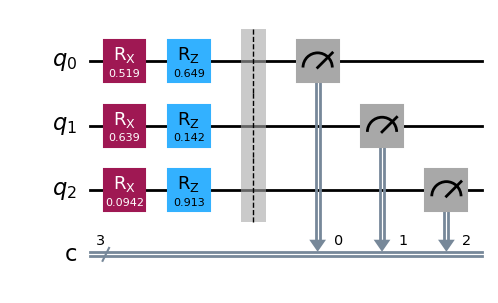

In [10]:
num_reps   = 1
num_1qg    = 2 #number of 1 qubit gates per qubit per rep
num_cbits  = num_qbits

params = np.random.rand(num_reps*num_1qg*num_qbits)
qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, params)

qc.draw('mpl', style='iqp')

Next we note the quantum backend we will run our circuit on. You could also choose a noisy backend such as one based on an actual IBMQ device or even the actual IBMQ device itself.

In [11]:
# Specify objective function and return cost associated with parameter choice
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 1000
# Initial parameters for all single qubit rotation gates
num_reps   = 1
num_1qg    = 2 #number of 1 qubit gates per qubit per rep
num_cbits  = num_qbits
basis_states = [format(current_value, '0'+str(num_qbits)+'b') for current_value in range(0,2**num_qbits)]
use_qiskit_function_flag = True

# Given the set of counts measured for each basis state return a vector of probabilities
def get_probability_distribution(counts):
  output_dist = []
  for current_key in basis_states:
    output_dist.append(counts.get(current_key, 0)/NUM_SHOTS)
  if (len(output_dist) == 1):
    output_dist.append(1 - output_dist[0])
  return output_dist

def objective_function(params):
  if use_qiskit_function_flag:
    #Qiskit built in function
    qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
    qc = qc.bind_parameters(params)
    qc.measure_all()
  else:
    #Manually create variational form
    qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, params)
  #Execute the quantum circuit to obtain the probability distribution associated with the current parameters
  trans_qc = transpile(qc, backend)
  qobj     = assemble(trans_qc, shots=NUM_SHOTS)
  result   = backend.run(qobj, shots=NUM_SHOTS).result()
  #Obtain the counts for each measured state, and convert those counts into a probability vector
  output_dist  = get_probability_distribution(result.get_counts(qc))
  #Then create a valid quantum state vector
  output_state = output_dist/(np.sqrt(sum(np.abs(output_dist)**2)))
  #Calculate the cost using state fidelity
  #cost = sum([np.abs(output_state[i] - target_dist[i]) for i in range(len(target_dist))])
  cost = state_fidelity(Statevector(target_state), Statevector(output_state))
  return (1-cost)

Initialise the COBYLA optimizer and run the algorithm

/tmp/ipykernel_55844/125658752.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc = qc.bind_parameters(params)
/tmp/ipykernel_55844/125658752.py:32: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result   = backend.run(qobj, shots=NUM_SHOTS).result()
/tmp/ipykernel_55844/562576366.py:12: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  qc = qc.bind_parameters(result_op.x)


Target State: [0.21545108 0.20406535 0.50192322 0.05665935 0.45533565 0.45868499
 0.14055332 0.46831962]
Obtained State: [0.27844907 0.10146873 0.22889457 0.59465394 0.60409289 0.25957117
 0.09438951 0.25485169]
State Fidelity: 0.5715720458466556
Parameters Found: [1.57151537 1.14584795 2.01149054 0.83668234 0.22181891 0.47876573]


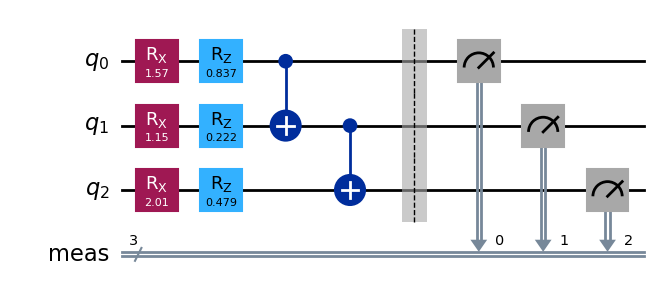

In [12]:
# Initialise COBYLA
optimizer = COBYLA(maxiter=10, tol=0.000001)
#optimizer  = GradientDescent(maxiter=10)

#Run Optimisation here
params     = np.random.rand(num_reps*num_1qg*num_qbits)
result_op  = optimizer.minimize(fun = objective_function, x0 = params)

#Obtain optimized circuit
#if use_qiskit_function_flag:
qc = EfficientSU2(num_qubits=num_qbits, entanglement="linear", su2_gates=['rx', 'rz'], reps=num_reps, skip_final_rotation_layer=True)
qc = qc.bind_parameters(result_op.x)
qc.measure_all()
#else:
#  qc = create_var_form_circuit(num_qbits, num_cbits, num_reps, result_op.x)

trans_qc     = transpile(qc, backend)
qobj         = assemble(trans_qc, shots=1000)
counts       = backend.run(trans_qc).result().get_counts()
output_dist  = get_probability_distribution(counts)
output_state = output_dist/np.sqrt(sum(np.abs(output_dist)**2))

print("Target State:", target_state)
print("Obtained State:", output_state)
print("State Fidelity:", state_fidelity(Statevector(target_state), Statevector(output_state)))
print("Parameters Found:", result_op.x)


qc.decompose().draw('mpl', fold=-1, style='iqp')
#qc.draw('mpl', style='iqp')

# Questions to consider

*   How does the number of shots in the quantum circuit affect the outcome?
*   How does the number of classical iterations for the optimizer affect the outcome?
*   How does the number of variational form repetitions affect the outcome?
*   What about the choice of classical optimizer?
*   Can you run this on a noisy backend and compare the performance of classical optimizers?